# Airlines - predict a delay

The goal of this classification model is to predict if a flight will delay or not.

In [1]:
## importing the libraries

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
# Reading the dataset

df = pd.read_csv('Airlines.csv')

In [3]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [4]:
## Checking the info of dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


There is no null values and all the types of the columns are correct, it is not necessary any change.

## EDA

In [5]:
df.nunique()

id             539383
Airline            18
Flight           6585
AirportFrom       293
AirportTo         293
DayOfWeek           7
Time             1131
Length            426
Delay               2
dtype: int64

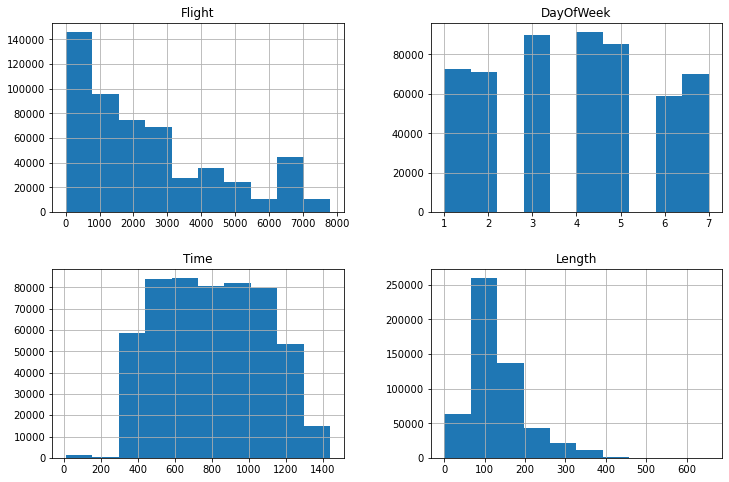

In [6]:
df.drop(columns=['id', 'Delay']).hist(figsize=(12,8))
plt.show()

In [7]:
(df['Delay'].value_counts()/df.shape[0] * 100).round(2)

0    55.46
1    44.54
Name: Delay, dtype: float64

44.54% of the flights suffer with delay.

In [8]:
fig = px.bar(df[df['Delay']==1].groupby('Airline').agg({'Delay':'count'}).reset_index().sort_values(by='Delay', ascending=False), x='Airline', y='Delay',template = 'plotly_dark', text_auto=True)
fig.show()

WN, DL and OO is the most problematic airlines.

In [9]:
fig = px.bar(df[df['Delay']==1].groupby('AirportFrom').agg({'Delay':'count'}).reset_index().sort_values(by='Delay', ascending=False), x='AirportFrom', y='Delay',template = 'plotly_dark', text_auto=True)
fig.show()
fig = px.bar(df[df['Delay']==1].groupby('AirportTo').agg({'Delay':'count'}).reset_index().sort_values(by='Delay', ascending=False), x='AirportTo', y='Delay',template = 'plotly_dark', text_auto=True)
fig.show()

In [10]:
df[df['Delay']==1].groupby('AirportFrom').agg({'Delay':'count'}).reset_index().sort_values(by='Delay', ascending=False)

,AirportFrom,Delay
16,ATL,14601
208,ORD,11906
79,DEN,9433
80,DFW,8809
154,LAX,8270
...,...,...
8,ADK,5
274,TEX,4
259,SJT,4
189,MMH,4


In [11]:
enc = OrdinalEncoder()
enc.fit(df[['AirportFrom', 'AirportTo']])

OrdinalEncoder()

In [12]:
df_enc = enc.transform(df[['AirportFrom', 'AirportTo']])

In [13]:
df_enc = pd.DataFrame(df_enc)
df_enc.columns = ['AirportFrom', 'AirportTo']
df_enc

,AirportFrom,AirportTo
0,253.0,135.0
1,217.0,60.0
2,154.0,80.0
3,253.0,80.0
4,14.0,252.0
...,...,...
539378,203.0,264.0
539379,252.0,16.0
539380,253.0,184.0
539381,128.0,253.0


In [14]:
df_final = df.copy()
df_final.drop(columns=['AirportFrom', 'AirportTo'], inplace=True)
df_final = pd.concat([df_final, df_enc], axis=1)

In [15]:
df_final.dtypes

id               int64
Airline         object
Flight           int64
DayOfWeek        int64
Time             int64
Length           int64
Delay            int64
AirportFrom    float64
AirportTo      float64
dtype: object

Checking the categorial columns to get_dummies

In [16]:
df_final = pd.get_dummies(df_final, prefix='al', drop_first=True)

In [17]:
df_final

,id,Flight,DayOfWeek,Time,Length,Delay,AirportFrom,AirportTo,al_AA,al_AS,...,al_FL,al_HA,al_MQ,al_OH,al_OO,al_UA,al_US,al_WN,al_XE,al_YV
0,1,269,3,15,205,1,253.0,135.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1558,3,15,222,1,217.0,60.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,2400,3,20,165,1,154.0,80.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2466,3,20,195,1,253.0,80.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,108,3,30,202,0,14.0,252.0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539378,539379,178,5,1439,326,0,203.0,264.0,0,0,...,0,0,0,0,0,0,0,0,0,0
539379,539380,398,5,1439,305,0,252.0,16.0,0,0,...,1,0,0,0,0,0,0,0,0,0
539380,539381,609,5,1439,255,0,253.0,184.0,0,0,...,1,0,0,0,0,0,0,0,0,0
539381,539382,78,5,1439,313,1,128.0,253.0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [18]:
df_final.columns = ['id', 'Flight', 'DayOfWeek', 'Time', 'Length', 'AirportFrom',
       'AirportTo', 'al_AA', 'al_AS', 'al_B6', 'al_CO', 'al_DL', 'al_EV',
       'al_F9', 'al_FL', 'al_HA', 'al_MQ', 'al_OH', 'al_OO', 'al_UA', 'al_US',
       'al_WN', 'al_XE', 'al_YV', 'Delay']

<AxesSubplot:>

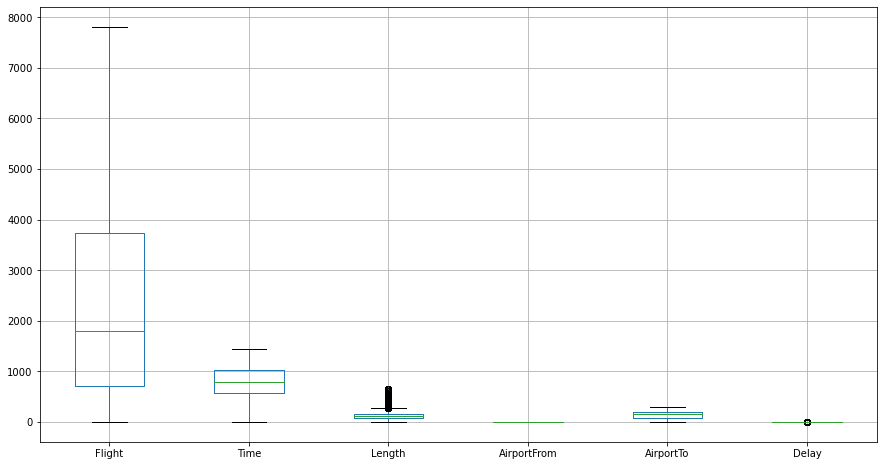

In [19]:
df_final[['Flight', 'Time', 'Length', 'AirportFrom', 'AirportTo', 'Delay']].boxplot(figsize=(15,8))

There is outliers in 'Length' columns, we are going to remove these outliers.

In [20]:
# Removing (statistical) outliers for Length

Q1 = df_final.Length.quantile(0.05)
Q3 = df_final.Length.quantile(0.95)
IQR = Q3 - Q1
df_final = df_final[(df_final.Length >= Q1 - 1.5*IQR) & (df_final.Length <= Q3 + 1.5*IQR)]

## Classificaton Model

In [30]:
scores_list = []
models_list = []

In [23]:
X = df_final.drop(columns=['id', 'Delay'])
y = df_final[['Delay']]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Standar Scaler

In [25]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [31]:
clf_LR = LogisticRegression()
clf_LR.fit(X_train_scaled, y_train.values.ravel())

y_pred_LR = clf_LR.predict(X_test_scaled)

acuracia_LR = accuracy_score(y_test, y_pred_LR)
f1_score_LR = f1_score(y_test, y_pred_LR)
recall_LR = recall_score(y_test, y_pred_LR)
precision_LR = precision_score(y_test, y_pred_LR)

models_list.append('Regressão Logística')
scores_list.append({'acuracia': acuracia_LR, 'f1-score': f1_score_LR, 'recall': recall_LR, 'precision': precision_LR})

print(f'Acurácia: {acuracia_LR:.2%}')
print(f'F-1 Score: {f1_score_LR:.2%}')
print(f'Recall: {recall_LR:.2%}')
print(f'Precision: {precision_LR:.2%}')

Acurácia: 97.91%
F-1 Score: 48.44%
Recall: 38.62%
Precision: 64.97%


### Random Forest

In [32]:
clf_RF = RandomForestClassifier()
clf_RF.fit(X_train_scaled, y_train.values.ravel())

y_pred_LR = clf_RF.predict(X_test_scaled)

acuracia_LR = accuracy_score(y_test, y_pred_LR)
f1_score_LR = f1_score(y_test, y_pred_LR)
recall_LR = recall_score(y_test, y_pred_LR)
precision_LR = precision_score(y_test, y_pred_LR)

models_list.append('Random Forest')
scores_list.append({'acuracia': acuracia_LR, 'f1-score': f1_score_LR, 'recall': recall_LR, 'precision': precision_LR})

print(f'Acurácia: {acuracia_LR:.2%}')
print(f'F-1 Score: {f1_score_LR:.2%}')
print(f'Recall: {recall_LR:.2%}')
print(f'Precision: {precision_LR:.2%}')

Acurácia: 100.00%
F-1 Score: 100.00%
Recall: 100.00%
Precision: 100.00%


### SVC

In [28]:
clf_SVC = SVC()
clf_SVC.fit(X_train_scaled, y_train.values.ravel())

y_pred_SVC = clf_SVC.predict(X_test_scaled)

acuracia_SVC = accuracy_score(y_test, y_pred_SVC)
f1_score_SVC = f1_score(y_test, y_pred_SVC)
recall_SVC = recall_score(y_test, y_pred_SVC)
precision_SVC = precision_score(y_test, y_pred_SVC)

models_list.append('SVC')
scores_list.append({'acuracia': acuracia_SVC, 'f1-score': f1_score_SVC, 'recall': recall_SVC, 'precision': precision_SVC})

print(f'Acurácia: {acuracia_SVC:.2%}')
print(f'F-1 Score: {f1_score_SVC:.2%}')
print(f'Recall: {recall_SVC:.2%}')
print(f'Precision: {precision_SVC:.2%}')

Acurácia: 100.00%
F-1 Score: 100.00%
Recall: 100.00%
Precision: 100.00%


### Metrics

In [35]:
df_scores = pd.DataFrame(scores_list, index=models_list)
df_scores

,acuracia,f1-score,recall,precision
Regressão Logística,0.979104,0.484446,0.386214,0.649693
Random Forest,1.000000,1.000000,1.000000,1.000000
SVC,1.000000,1.000000,1.000000,1.000000
